In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/mid_term_nlp/finance'

/content/drive/MyDrive/mid_term_nlp/finance


In [ ]:
import numpy as np
import pandas as pd
from utils import *
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!python -m spacy download en_core_web_md
# Load the spaCy NLP model
nlp = spacy.load("en_core_web_md")

2024-01-29 06:58:49.581710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 06:58:49.581762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 06:58:49.582963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 06:58:51.237724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df['Sentiment'].replace({'positive':1,'negative':0, 'neutral':2},inplace=True)

In [ ]:
df = shuffle(df)
# df = df[:10000]

In [ ]:
df.head()

,Sentence,Sentiment
3907,Repeats sees 2008 operating profit down y-y ( ...,2
3350,Reported operating margin was a negative 5.9 % .,2
23,The company plans to increase the unit 's spec...,2
4835,$AMRN You can many times find top and bottoms ...,0
1002,$CTRP not a bad long chart now that it's throu...,1


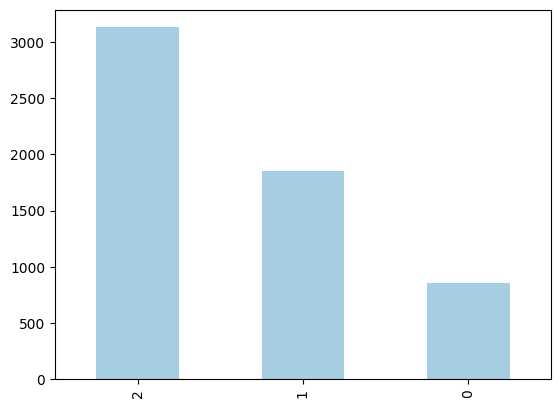

In [ ]:
axplot=df.Sentiment.value_counts().plot(kind='bar', colormap='Paired')
plt.show()

In [ ]:
df['Sentence'] = df['Sentence'].apply(clean_html)
df['Sentence'] = df['Sentence'].apply(convert_lower)
df['Sentence'] = df['Sentence'].apply(remove_special)
df['Sentence'] = df['Sentence'].apply(remove_stopwords)
df['Sentence'] = df['Sentence'].apply(stem_words)
df['Sentence'] = df['Sentence'].apply(join_back)

In [ ]:
print('df shape:', df.shape)
df.head()

df shape: (5842, 2)


,Sentence,Sentiment
3907,repeat see 2008 oper profit report helsinki ne...,2
3350,report oper margin neg 5 9,2
23,compani plan increas unit specialist staff sev...,2
4835,amrn mani time find top bottom short start rej...,0
1002,ctrp bad long chart sma100 resist,1


In [ ]:
X = []
y = []
# Perform Tokenization
for idx, rw in df.iterrows():
 comments = rw["Sentence"]
 rating = rw["Sentiment"]
 y.append(rating)
 mtoks = [token.text for token in nlp(comments)]
 X.append(mtoks)

In [ ]:
# Create ktoken and perform tokenization
ktoken = Tokenizer(lower=True)
ktoken.fit_on_texts(X)
# Create utterance sequences object
X = ktoken.texts_to_sequences(X)

In [ ]:
MLEN = 50
# Create pad utterance sequence object
X = pad_sequences(X, MLEN, padding="post")

In [ ]:
# Convert the ps_utterance into numpy arrays
X = np.array(X)
# Create the category list (catlist)
y = np.array(y)

In [ ]:
y = y.reshape(y.shape[0] , 1)

In [ ]:
lb = LabelBinarizer()
y = lb.fit_transform(y)

In [ ]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5842, 50)
y shape: (5842, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

# LSTM Model

In [ ]:
input = Input(shape = (X_train[0].shape))
embedding = Embedding(input_dim = len(ktoken.word_index)+1, output_dim = 100)(input)
x = Conv1D(128, 3, padding = 'same', activation = 'relu')(embedding)
x = MaxPooling1D(pool_size = 2)(x)
x = Conv1D(64, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Conv1D(32, 3, padding = 'same', activation = 'relu')(x)
x = LSTM(128, dropout = 0.2, return_sequences=True)(x)
x = LSTM(32)(x)
x = Dense(128)(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

In [ ]:
lstm_model = Model(inputs=[input],outputs=[output], name='LSTM_Model')
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 50, 100)           881400    
                                                                 
 conv1d_73 (Conv1D)          (None, 50, 128)           38528     
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 25, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_74 (Conv1D)          (None, 25, 64)            24640     
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 12, 64)            0         
 ng1D)                                                  

In [ ]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = lstm_model.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 40,
                         validation_split = 0.2)

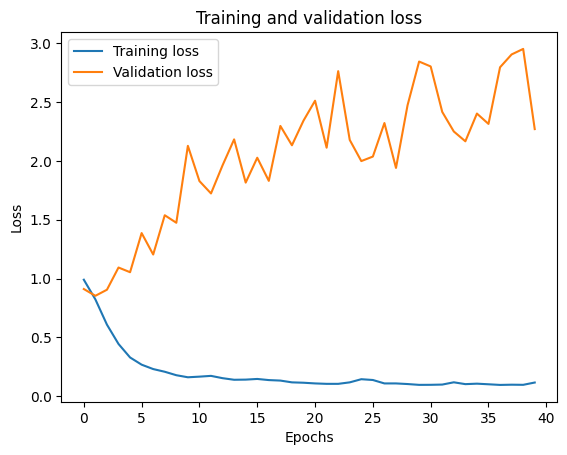

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(0, len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

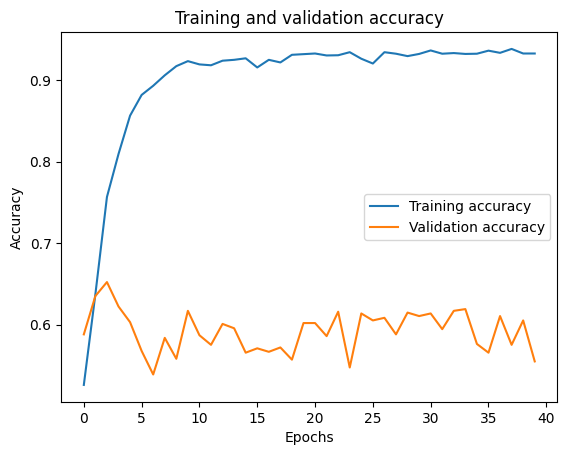

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(0, len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred1 = lstm_model.predict(X_test)

37/37 [==============================] - 1s 7ms/step


In [ ]:
y_pred1.shape

(1169, 3)

In [ ]:
y_pred1 = lb.inverse_transform(y_pred1)
# y_test = lb.inverse_transform(y_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred1)
print(f"LSTM Accuracy:{accuracy * 100:.3f}%")
recall = recall_score(y_test, y_pred1, average='macro')
print(f"LSTM Recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred1, average='macro')
print(f"LSTM F1:{f1 * 100:.3f}%")

LSTM Accuracy:62.703%
LSTM Recall:57.404%
LSTM F1:56.537%


In [ ]:
label = ['Negative', 'Positive', 'Neutral']

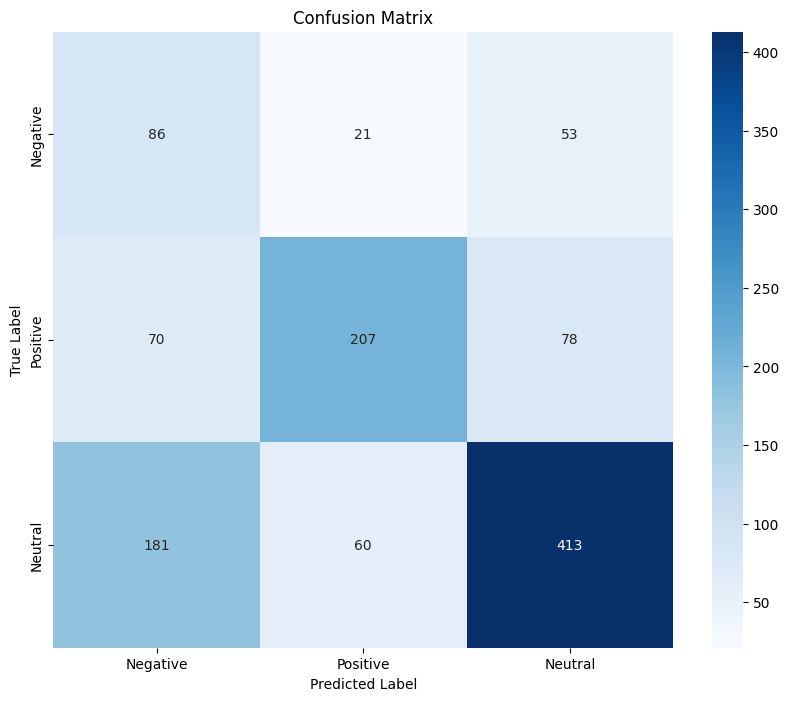

In [ ]:
cm = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# CNN

In [ ]:
input = Input(shape = (X_train[0].shape))
embedding = Embedding(input_dim = len(ktoken.word_index)+1, output_dim = 300)(input)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(embedding)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, padding = 'same', activation = 'relu')(x)
x = Conv1D(128, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, padding = 'same', activation = 'relu')(x)
x = Conv1D(64, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation = 'relu')(x)
x = Dense(16, activation = 'relu')(x)
output = Dense(3, activation='softmax')(x)

In [ ]:
cnn_model = Model(inputs=[input],outputs=[output], name='CNN_Model')
cnn_model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_24 (Embedding)    (None, 50, 300)           2644200   
                                                                 
 conv1d_65 (Conv1D)          (None, 50, 256)           230656    
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 25, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_66 (Conv1D)          (None, 25, 256)           196864    
                                                                 
 conv1d_67 (Conv1D)          (None, 25, 128)           98432     
                                                         

In [ ]:
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = cnn_model.fit(x = X_train,
                         y = y_train,
                         batch_size = 32,
                         epochs = 100,
                         validation_split = 0.2)

Epoch 1/100
117/117 [==============================] - 17s 112ms/step - loss: 0.9655 - accuracy: 0.5268 - val_loss: 0.9020 - val_accuracy: 0.5882
Epoch 2/100
117/117 [==============================] - 5s 42ms/step - loss: 0.7679 - accuracy: 0.6677 - val_loss: 0.8387 - val_accuracy: 0.6289
Epoch 3/100
117/117 [==============================] - 2s 20ms/step - loss: 0.5545 - accuracy: 0.7638 - val_loss: 0.9582 - val_accuracy: 0.6460
Epoch 4/100
117/117 [==============================] - 2s 16ms/step - loss: 0.3770 - accuracy: 0.8159 - val_loss: 1.1585 - val_accuracy: 0.6684
Epoch 5/100
117/117 [==============================] - 2s 17ms/step - loss: 0.2817 - accuracy: 0.8735 - val_loss: 1.4229 - val_accuracy: 0.6439
Epoch 6/100
117/117 [==============================] - 2s 15ms/step - loss: 0.2236 - accuracy: 0.8967 - val_loss: 1.5045 - val_accuracy: 0.6214
Epoch 7/100
117/117 [==============================] - 2s 13ms/step - loss: 0.1872 - accuracy: 0.9072 - val_loss: 1.9754 - val_accurac

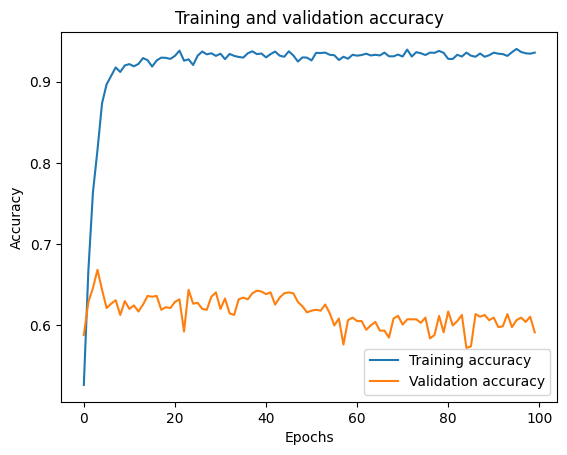

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(0, len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred2 = cnn_model.predict(X_test)

37/37 [==============================] - 0s 9ms/step


In [ ]:
y_test.shape

(1169,)

In [ ]:
y_pred2.shape

(1169, 3)

In [ ]:
y_pred2 = lb.inverse_transform(y_pred2)

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"CNN Accuracy:{accuracy * 100:.3f}%")
recall = recall_score(y_test, y_pred2, average='macro')
print(f"CNN Recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred2, average='macro')
print(f"CNN F1:{f1 * 100:.3f}%")

CNN Accuracy:61.420%
CNN Recall:58.243%
CNN F1:56.222%


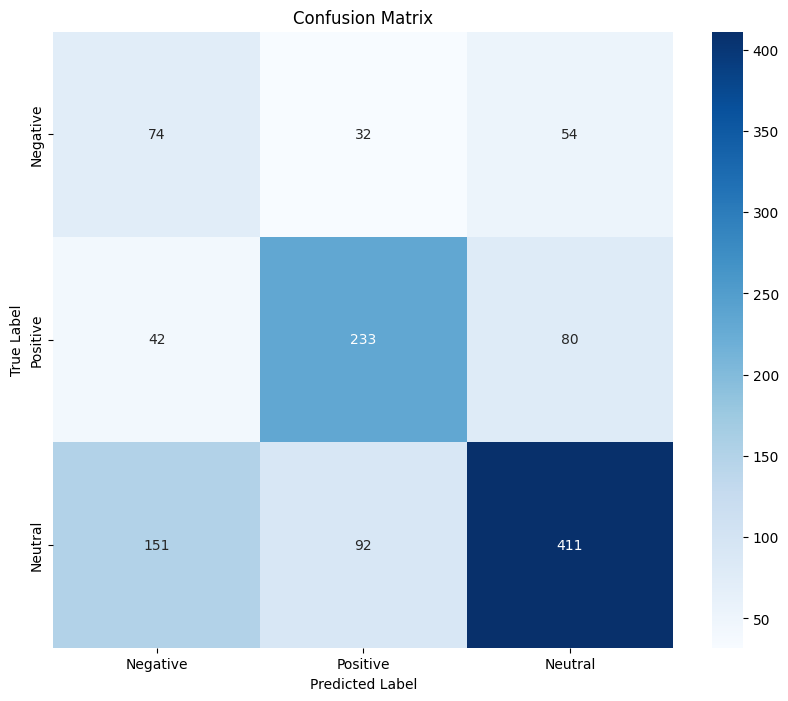

In [ ]:
cm = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()